In [ ]:
#libraries used in this study
library(tidyverse)
library(ggplot2)
library(survival)
library(survminer)
library(survivalROC)

# Part I : Dataset Resort Booking (H1)

## 1. Dataset exploration 
**Loading data**

In [6]:
data_raw <- read_csv("H1_resort.csv", col_types = cols(IsCanceled='i', Adults = 'i', Children ='i', Babies ='i'))
head(data_raw,1)

IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,...,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<date>
0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01


We converted a couple of columns into integer. Now we do some transformation on the dataset data_raw: 
- Convert the arrival date into one column
- According to the article, we can estimate the **cancellation date** based on ReservationStatus, ReservationStatusDate (date of booking update) and booking date. This covariate is a gauge relevant only if cancelation. I name it **BookToCancel**. 


In [8]:
# Tranform the date of arrival and calculate the date of cancellation if cancellation happens
format_date <- function(x) as.Date(x, format = "%Y/%B/%d")
#Concatenate Year, Month, Date of arrivale date
string_date = paste(as.character(data_raw$ArrivalDateYear), 
          data_raw$ArrivalDateMonth, 
          as.character(data_raw$ArrivalDateDayOfMonth), 
          sep="/")
data_raw <- mutate(data_raw,
               ADR = as.integer(ADR),
               ArrivalDate = format_date(string_date),
               BookingDate = ArrivalDate - LeadTime,
               BookToCancel = as.numeric(ReservationStatusDate - BookingDate)
               )
dim(data_raw)

[1] 40060    34

### ``Checking the validity of the data``

Due to the fact that in reality, the elapsed time between the booking date and the cancelation date (*BookToCancel*) is in general smaller than the elapsed time between the booking date and the arrival date (*LeadTime*). There would be a human mistake when entering the data at this point, for some reasons a staff can enter the reservation status in the field *ReservationStatusDate* few days later for a cancelled booking ! 

In this respect, we want to check the "unsual" bookings by comparing BookToCancel (in days) with LeadTime (in days) for the cancelations status being True (Iscanceled = 1) and False (IsCanceled = 0)

In [9]:
c(dim(filter(data_raw, BookToCancel > LeadTime, IsCanceled == 1)),
  dim(filter(data_raw, BookToCancel < LeadTime, IsCanceled == 0)))

[1]  0 34  0 34

> The booking time of the dataset is totally correct, there is no exception.

We check now the censored data (*IsCanceled* status). We can see below that the number of cancellation of the entire dataset is the same as the one extracted from the *IsCanceled* status following each type of cancellation (Canceled or No-Show)

In [10]:
table(data_raw$ReservationStatus)


 Canceled Check-Out   No-Show 
    10831     28938       291 

In [11]:
table(filter(data_raw, IsCanceled == 1)$ReservationStatus)


Canceled  No-Show 
   10831      291 

**Select the columns for survival analysis**

This is very important section where we define below the censored data and the features (covariates) of our analysis. Questions raised for the analysis are discussed as follows :

- For the censored data: we have time duration (*LeadTime*, *BookToCancel*) and we have event observation (*IsCanceled*). The problem of our dataset is which one of the time duration we must choose to have a "faithful/correct" survival analysis. We cope to the situation where we are dealing with  **not homogeneous** population in which there is no equal predefined time limite for each experience. That means each observation (booking canceled or not canceled) is always biased whatever we take *LeadTime* (elapsed time from booking to arrival date) or *BookToCancel* (booking to cancellation) as duration time.<br>
  The survival analysis of this problem is indeed very complicated. In reality, one should deal with specific models (for intance, survival model called *Discrete Time Proportional Odds* for airline ticketing analysis by [D. C. Iliescu *et al.*](http://web.mit.edu/11.951/oldstuff/albacete/Other_Documents/Europe%20Transport%20Conference/applied_methods_in_tra/analysis_of_us_air1689.pdf)) to analyse and interprete the results properly. In the framework of this project, we simplify this issue by lifting out this bias imposed by the arrival date on each observation:  we will take *LeadTime* as time outcome, the time duration for an experience is therefore estimated from booking until arrival date. Henceforth, we must be aware that the interpretation of the survival results in this project has to be based on this simplified pattern. <br>  
  
  
- For the features : we add additionnal features *totalNights* and *havingKids* based on others (see code for definition). Taking into account the booking category *resort*, we select important features including categorial and continous variables for which we think they exhibit most impact on this kind of booking: *StaysInWeekendNights, Adults, Babies, ADR, DistributionChannel, DepositType, totalNights, havingKids, ArrivalDateMonth* 


In [128]:
selected_cols = c("IsCanceled", "LeadTime", "ArrivalDateMonth", "StaysInWeekendNights", 
                  "StaysInWeekNights","Adults", "Children",
                  "Babies", "ADR", "DistributionChannel", "DepositType", "BookToCancel")
data_selected <- select(data_raw, selected_cols)

In [15]:
resort <- mutate(filter(data_selected, LeadTime <= 548),
                LeadTime = LeadTime/30.5,   # LeadTime in months
                havingKids = Children + Babies,
                totalNights = StaysInWeekNights + StaysInWeekendNights
                )
head(resort,1)
dim(resort)

IsCanceled,LeadTime,ArrivalDateMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,ADR,DistributionChannel,DepositType,BookToCancel,havingKids,totalNights
<int>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>
0,11.21311,July,0,0,2,0,0,0,Direct,No Deposit,342,0,0


[1] 40058    14

**Statistical description about the dataset "resort" we are going to work with :**

In [16]:
# output of some categorical features : is there missing data ?
table(resort$IsCanceled, useNA ="always")
table(data_selected$Babies, useNA ="always")
table(data_selected$DistributionChannel, useNA ="always")
table(data_selected$DepositType,useNA ="always")


    0     1  <NA> 
28936 11122     0 


    0     1     2  <NA> 
39512   539     9     0 


Corporate    Direct     TA/TO Undefined      <NA> 
     3269      7865     28925         1         0 


No Deposit Non Refund Refundable       <NA> 
     38199       1719        142          0 

In [23]:
summary(resort)

   IsCanceled        LeadTime       ArrivalDateMonth   StaysInWeekendNights
 Min.   :0.0000   Min.   : 0.0000   Length:40058       Min.   : 0.00       
 1st Qu.:0.0000   1st Qu.: 0.3279   Class :character   1st Qu.: 0.00       
 Median :0.0000   Median : 1.8689   Mode  :character   Median : 1.00       
 Mean   :0.2776   Mean   : 3.0375                      Mean   : 1.19       
 3rd Qu.:1.0000   3rd Qu.: 5.0820                      3rd Qu.: 2.00       
 Max.   :1.0000   Max.   :17.7705                      Max.   :19.00       
 StaysInWeekNights     Adults          Children           Babies      
 Min.   : 0.000    Min.   : 0.000   Min.   : 0.0000   Min.   :0.0000  
 1st Qu.: 1.000    1st Qu.: 2.000   1st Qu.: 0.0000   1st Qu.:0.0000  
 Median : 3.000    Median : 2.000   Median : 0.0000   Median :0.0000  
 Mean   : 3.128    Mean   : 1.867   Mean   : 0.1287   Mean   :0.0139  
 3rd Qu.: 5.000    3rd Qu.: 2.000   3rd Qu.: 0.0000   3rd Qu.:0.0000  
 Max.   :50.000    Max.   :55.000   Max.  

> We notice that *ArrivalDateMonth, Country, DistributionChannel, DepositType* are string features. We will need to categorize them when we want to use.


**Visualization of the dataset**

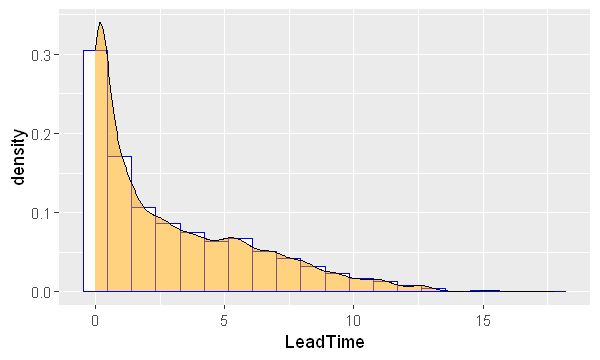

In [20]:
resort_df <- as.data.frame(resort)
options(repr.plot.width=5, repr.plot.height=3)
ggplot(resort_df,aes(x=LeadTime)) + 
    geom_histogram(aes(y=..density..), color = "blue", fill = "white", bins = 20) +
    geom_density(alpha = 0.5, fill = "orange")

> - The probability distribution curve is of exponential form
> - The number of bookings for a time booking (booking-arrival date) within 1-2 month mostly dominates the total number of booking

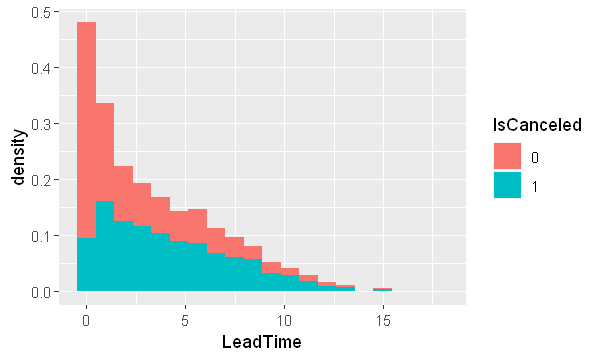

In [22]:
# Here are histograms for reservation statuses no-cancelation (0) and cancelation (1) versus time (in months)
resort_df$IsCanceled <- factor(resort_df$IsCanceled, levels = c("0", "1"))
options(repr.plot.width=5, repr.plot.height=3)
ggplot(resort_df,aes(x=LeadTime, fill = IsCanceled)) +          
    geom_histogram( aes(y=..density..), bins = 20) 
          

> A high density of cancellation (IsCanceled = 1) for a short booking period is vey prononced as compared to a long booking period over a the whole length of the sample. However, the tendency would be inverse if we consider the ratio **cancellation/no-cancellation (1/0)**: larger the booking period, higher the ratio is. 

**Testing the dependence of the observation (booking cancellation or not) over some features**

We have selected few features. To strenghen our intuitive arguments, we can perform the test of interaction of features with the booking observation. Here are few features we want to test :

- *DistributionChannel*
- Number of baby, *Babies*
- *DepositType*

In [24]:
with(resort, round(100 * prop.table(table(IsCanceled, DistributionChannel), 2), 1))
with(resort, chisq.test(table(IsCanceled, DistributionChannel)))

          DistributionChannel
IsCanceled Corporate Direct TA/TO Undefined
         0      79.0   83.1  68.5     100.0
         1      21.0   16.9  31.5       0.0


	Pearson's Chi-squared test

data:  table(IsCanceled, DistributionChannel)
X-squared = 741.26, df = 3, p-value < 2.2e-16


> - The frequency table shows that booking issued from traveling agencies (TA/TO) has a highest rate of cancelation while the undefined booking has no cancelation.
> - Chi-square test (of independence) : we see that the p-value is extremely small, we don't accept H$_{0}$ hypothesis, meaning that there is a certain relationship between the distribution channel and booking cancelation. 

Other retionships of covariates with IsCanceled are also relevant and in line with our feature selection: 

In [25]:
# IsCanceled vs Babies : 
with(resort, chisq.test(table(IsCanceled, Babies)))


	Pearson's Chi-squared test

data:  table(IsCanceled, Babies)
X-squared = 22.339, df = 2, p-value = 1.41e-05


In [26]:
# IsCanceled vs DepositType
with(resort, chisq.test(table(IsCanceled, DepositType)))


	Pearson's Chi-squared test

data:  table(IsCanceled, DepositType)
X-squared = 4174, df = 2, p-value < 2.2e-16


---
## 2. Survival analysis of the dataset 

The purpose of this section is to dertermine booking survival curves (Kaplan-Meier), hazard analysis (Cox proportional hazard) and the impact of feature selection on the technologies used. We also perform logrank test to figure out the effect of groups in covariates on the censored outcome.

Note that we employ a couple of covariates to illustrate our analysis, which may be extended to others eventually. 


### a. Non-parametric analysis

We investigate first  ``Kaplan-Meier`` (KM) model. The computation is performed over entire dataset *resort*.

- **KM estimator without covariates**

In [27]:
fit.KM <- survfit(Surv(LeadTime, IsCanceled) ~ 1, data = resort)
fit.KM

Call: survfit(formula = Surv(LeadTime, IsCanceled) ~ 1, data = resort)

       n   events   median  0.95LCL  0.95UCL 
40058.00 11122.00     7.57     7.38     7.70 

> A half of booking will be canceled for booking time of about 7.6 months within a very tiny 5%-level confidence interval ($\pm$ 1 week).

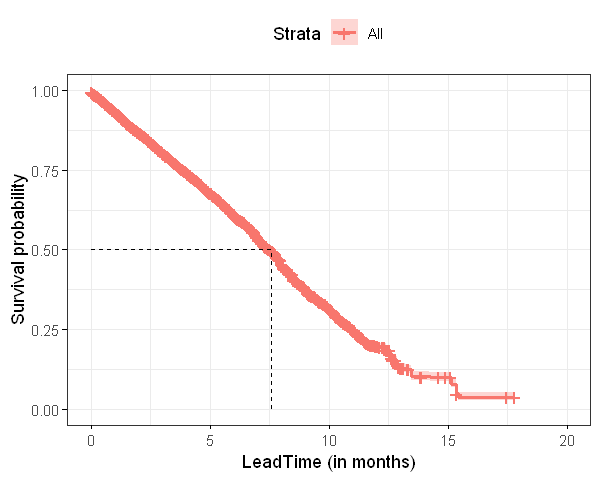

In [30]:
options(repr.plot.width=5, repr.plot.height=4)
ggsurvplot(fit.KM, risk.table = FALSE, surv.median.line = "hv", main = "Kaplan-Meier estimators for booking survival", 
           ylab = "Survival probability", xlab = "LeadTime (in months)", ggtheme = theme_bw())

> The KM estimator shows the survival booking curve (no-cancelation probability) as a function of booking time. Larger a booking period is, higher a booking cancellation probability is (same observation with histogram). <br>
>Note that we intentionnally stop the experience for booking time of 1.5 years (LeadTime < 548 days).

- **KM estimator with covariates : we use stratified ``logrank test`` to compare different levels of selected covariates**


In [31]:
# Delete the "Undefined" group in DistributionCHannel (because of only 1 data) 
# Factorize each categorial covariate into groups 
resort <- filter(resort, DistributionChannel != "Undefined")
resortKMcov <- resort %>%
               mutate(DistributionChannel = factor(DistributionChannel, levels = c("Direct", "Corporate", "TA/TO")),
                      Babies = factor(Babies, levels = c("0", "1", "2")),
                      DepositType = factor(DepositType, levels = c("No Deposit", "Non Refund", "Refundable")))    

In [32]:
table(resortKMcov$DistributionChannel) 
table(resortKMcov$DepositType)
table(resortKMcov$Babies)


   Direct Corporate     TA/TO 
     7863      3269     28925 


No Deposit Non Refund Refundable 
     38196       1719        142 


    0     1     2 
39509   539     9 

Call:
survdiff(formula = Surv(LeadTime, IsCanceled) ~ Babies, data = resortKMcov)

             N Observed Expected (O-E)^2/E (O-E)^2/V
Babies=0 39509    11019 10974.61     0.180    13.615
Babies=1   539      101   143.98    12.830    13.062
Babies=2     9        2     3.41     0.582     0.586

 Chisq= 13.7  on 2 degrees of freedom, p= 0.001 

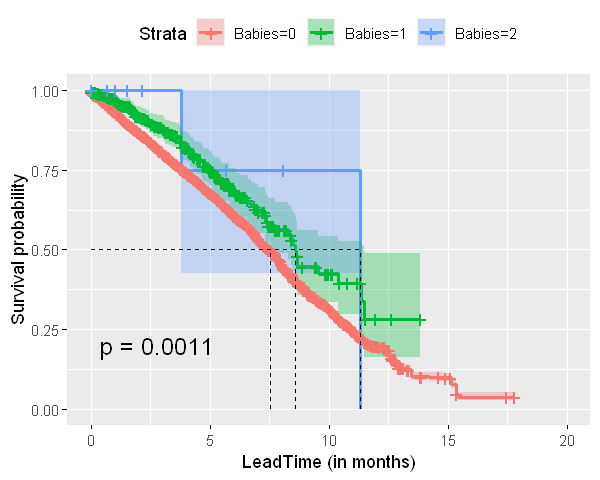

In [35]:
# We now perform the test with "Babies" feature
fit.logrank <- survdiff(Surv(LeadTime, IsCanceled) ~ Babies, data = resortKMcov)
fit.logrank
options(repr.plot.width=5, repr.plot.height=4)
ggsurvplot(survfit(Surv(LeadTime, IsCanceled) ~ Babies, data = resortKMcov), pval = TRUE, risk.table = FALSE,
           surv.median.line = "hv", main = "Kaplan-Meier estimators for booking", 
           ylab = "Survival probability", xlab = "LeadTime (in months)",conf.int = TRUE, ggtheme = theme())

We did the same test with other covariates (we don't show corresponding curves for a sake of space)

In [36]:
# Test with "DistributionChannel" feature
fit.logrank <- survdiff(Surv(LeadTime, IsCanceled) ~ DistributionChannel, data = resortKMcov)
fit.logrank

Call:
survdiff(formula = Surv(LeadTime, IsCanceled) ~ DistributionChannel, 
    data = resortKMcov)

                                  N Observed Expected (O-E)^2/E (O-E)^2/V
DistributionChannel=Direct     7863     1325     1502    20.824    24.288
DistributionChannel=Corporate  3269      688      699     0.171     0.189
DistributionChannel=TA/TO     28925     9109     8921     3.953    20.298

 Chisq= 25.2  on 2 degrees of freedom, p= 3e-06 

In [37]:
# Test with "DepositType" feature
fit.logrank <- survdiff(Surv(LeadTime, IsCanceled) ~ DepositType, data = resortKMcov)
fit.logrank

Call:
survdiff(formula = Surv(LeadTime, IsCanceled) ~ DepositType, 
    data = resortKMcov)

                           N Observed Expected (O-E)^2/E (O-E)^2/V
DepositType=No Deposit 38196     9450  10003.1      30.6     311.9
DepositType=Non Refund  1719     1650   1050.8     341.7     387.6
DepositType=Refundable   142       22     68.1      31.2      31.6

 Chisq= 414  on 2 degrees of freedom, p= <2e-16 

> All the p-value are very small, that means we do NOT accept the null hypothesis, the effect of each group in *Babies*, *DistributionChannel* and *DepositType* on survival outcome is statistically significant. 

The effect of each group can also be confirmed by using proportional hazard technique (log(-log(survival)). We show right below the *cloglog* curves of *Babies* covariate for which the curves of each group are relatively paralelle, indicating a significant effect of these groups.

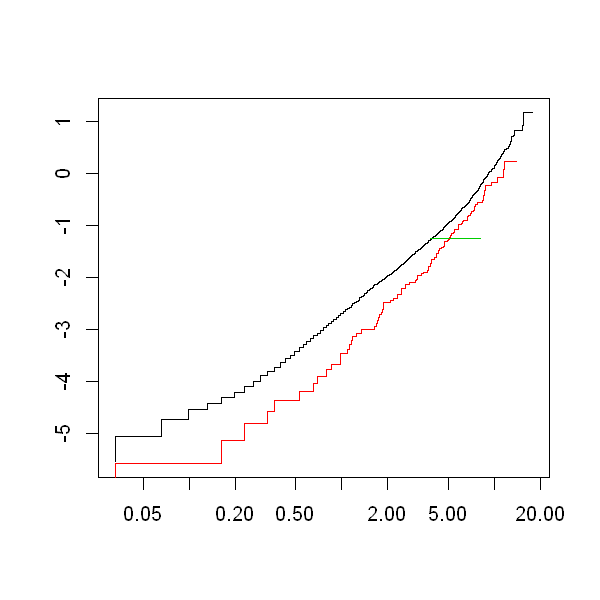

In [39]:
PH <- survfit(Surv(LeadTime, IsCanceled) ~ Babies, data = resortKMcov)
options(repr.plot.width=5, repr.plot.height=5)
plot(PH, fun="cloglog", col = c(1:3))

We can think that the DepositType is more and less dependent on the fact that the booking involves or not the number (of groups) of Babies or DistributionChannel. The distribution of numbers of baby or type of distribution channel can bias the *DepositType* test above. In this situation, we can perfom a ``stratified logrank test`` to check the effect. For instance, we can check the case of **DepositType vs Babies**:

In [40]:
with(resortKMcov, prop.table(table(DepositType, Babies), 1))

            Babies
DepositType             0            1            2
  No Deposit 0.9856529480 0.0141114253 0.0002356268
  Non Refund 1.0000000000 0.0000000000 0.0000000000
  Refundable 1.0000000000 0.0000000000 0.0000000000

> This table clearly shows a the distribution of the number of babies in each groups of *DepositType* is not homogenous. Let's do a stratifield *Babies* and do the test again : 

Call:
survdiff(formula = Surv(LeadTime, IsCanceled) ~ DepositType + 
    strata(Babies), data = resortKMcov)

                           N Observed Expected (O-E)^2/E (O-E)^2/V
DepositType=No Deposit 38196     9450   9999.1      30.2     306.8
DepositType=Non Refund  1719     1650   1054.6     336.2     381.9
DepositType=Refundable   142       22     68.4      31.4      31.8

 Chisq= 408  on 2 degrees of freedom, p= <2e-16 

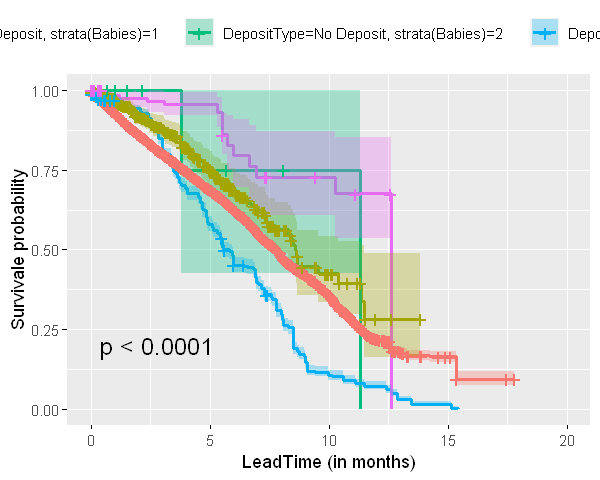

In [42]:
# stratafied logrank
fit.logrank <- survdiff(Surv(LeadTime, IsCanceled) ~ DepositType + strata(Babies) , data = resortKMcov)
fit.logrank
options(repr.plot.width=5, repr.plot.height=4)
ggsurvplot(survfit(Surv(LeadTime, IsCanceled) ~ DepositType + strata(Babies), data = resortKMcov), pval = TRUE, 
           risk.table = FALSE, ylab = "Survivale probability", xlab = "LeadTime (in months)", conf.int = TRUE,
           ggtheme = theme())

> It is shown that the p-value is still very small, that means the the impact of *DepositType* on the outcome is not biased  by the distribution of each group in *Babies*

### b. Cox Proportional Hazard (coxph) : semi-parametric model
**To step further in survival analysis : we investigate our dataset by using Cox proportional Hazard (coxph) model. <br>
We will highlight the following points :**
   - Deal with mutil-covariates
   - Estimation with continuous covariates
   - Hazard risk ratio ($exp(\beta$)) associated with a covariate : key to assess the fluctuations of a covariate on the survival outcome 
   - Regression prediction 

 

We start by using coxph() for a single covariate, for instance, *DepositType*

In [43]:
fit.coxph_singleCov <- coxph(Surv(LeadTime, IsCanceled) ~ DepositType, data = resortKMcov)
summary(fit.coxph_singleCov)

Call:
coxph(formula = Surv(LeadTime, IsCanceled) ~ DepositType, data = resortKMcov)

  n= 40057, number of events= 11122 

                          coef exp(coef) se(coef)      z Pr(>|z|)    
DepositTypeNon Refund  0.52667   1.69328  0.02694 19.546  < 2e-16 ***
DepositTypeRefundable -1.07297   0.34199  0.21348 -5.026 5.01e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                      exp(coef) exp(-coef) lower .95 upper .95
DepositTypeNon Refund     1.693     0.5906    1.6062    1.7851
DepositTypeRefundable     0.342     2.9241    0.2251    0.5197

Concordance= 0.51  (se = 0.001 )
Likelihood ratio test= 381.5  on 2 df,   p=<2e-16
Wald test            = 411.2  on 2 df,   p=<2e-16
Score (logrank) test = 423.9  on 2 df,   p=<2e-16


> - All p-values are much less than 0.05 : very highly significant effect between the groups of the feature _DepositType_
> - DepositType feature has 3 groups (*No Deposit, Non Refund, Refundable*) and coxph extimation takes _No Deposit_ as reference (in the framework of "treatment contrasts" by R).
> - For _Non Refund_ group : the coefficient $\beta$  is positive, meaning that the (cancellation) risk of _Non Refund_ is higher than _No depostit_. There is about 69.3% higher risk (of cancellation) in _Non Refund_ group higher than in  _No Deposit_ group. The confidence interval here is  [60.6% - 78.5%]. 
> - For _Refundable_ type : the coefficient $\beta$  is negative, meaning that the hazard risk of cancellation in _Refundable_ group is 65.8% higher than the risk in _No Deposit_. The confidence interval here is  [48.0% - 77.5%].


**Cox model with multi-covariates** <br>
In the following, we will do some transformation of several categorial covariates to simplify the reading and interpretation of the results :  we group each features into two groups. 

In [46]:
resortCoxph <- resort %>%
            mutate(DistributionChannel = factor(ifelse(DistributionChannel=="Direct", "Direct", "Mediator"), 
                                        levels = c("Direct", "Mediator")),                                                 
                   Babies = factor(ifelse(Babies==0,"No", "Yes"), levels = c("No", "Yes")),
                   DepositType = factor(ifelse(DepositType=="Non Refund", "Non Refund", "Refund"),
                                        levels = c("Non Refund", "Refund")),
                   ArrivalDateMonth = factor(ifelse(ArrivalDateMonth == c("June", "July", "August", "September"),
                                                     "Summer", "Other Season"), 
                                         level = c("Summer", "Other Season")))

In [47]:
# Model composed of two categorial covariates : DepositType + ArrivalDateMonth
fit.coxph_1 <- coxph(Surv(LeadTime, IsCanceled) ~ DepositType + ArrivalDateMonth, 
                   data = resortCoxph)
summary(fit.coxph_1)

Call:
coxph(formula = Surv(LeadTime, IsCanceled) ~ DepositType + ArrivalDateMonth, 
    data = resortCoxph)

  n= 40057, number of events= 11122 

                                 coef exp(coef) se(coef)       z Pr(>|z|)    
DepositTypeRefund            -0.52560   0.59120  0.02696 -19.493  < 2e-16 ***
ArrivalDateMonthOther Season  0.14167   1.15220  0.03002   4.719 2.37e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                             exp(coef) exp(-coef) lower .95 upper .95
DepositTypeRefund               0.5912     1.6915    0.5608    0.6233
ArrivalDateMonthOther Season    1.1522     0.8679    1.0864    1.2220

Concordance= 0.519  (se = 0.002 )
Likelihood ratio test= 367.3  on 2 df,   p=<2e-16
Wald test            = 410.7  on 2 df,   p=<2e-16
Score (logrank) test = 419.7  on 2 df,   p=<2e-16


> - All p-values of the test are << 0.05. Statistically, there is a large significant effect between groups of the features on the outcome. 
> - For *DepositType* : *Refund* group has a negative impact, the hazard risk in *No Refund* is higher than *Non Refund* group, the hazard risk in *Refund* is 40.9% less than the one in *Non refund* with a confidence interval= [37.7% - 44.0%] and a small standard error.
> - For *ArrivalDateMonth* : the effect is positive, the hazard risk in *Summer* is 15.2% higher than in *Other Season* with a confidence interval [8.6% - 22.2%] and a small standard error.

In [48]:
# Model composed of continuous covariates : 
fit.coxph_2 <- coxph(Surv(LeadTime, IsCanceled) ~ ADR + totalNights + Adults + havingKids,data = resortCoxph)
summary(fit.coxph_2)

Call:
coxph(formula = Surv(LeadTime, IsCanceled) ~ ADR + totalNights + 
    Adults + havingKids, data = resortCoxph)

  n= 40057, number of events= 11122 

                  coef  exp(coef)   se(coef)       z Pr(>|z|)    
ADR          0.0035803  1.0035868  0.0001723  20.776  < 2e-16 ***
totalNights -0.1155091  0.8909125  0.0035441 -32.592  < 2e-16 ***
Adults      -0.0290552  0.9713628  0.0128073  -2.269   0.0233 *  
havingKids   0.1005614  1.1057915  0.0200992   5.003 5.64e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

            exp(coef) exp(-coef) lower .95 upper .95
ADR            1.0036     0.9964    1.0032    1.0039
totalNights    0.8909     1.1224    0.8847    0.8971
Adults         0.9714     1.0295    0.9473    0.9961
havingKids     1.1058     0.9043    1.0631    1.1502

Concordance= 0.654  (se = 0.003 )
Likelihood ratio test= 1692  on 4 df,   p=<2e-16
Wald test            = 1569  on 4 df,   p=<2e-16
Score (logrank) test = 1491  on 4 df,   p=<2e-16

> - All p-values are  smaller than 0.05: the risk hazard effects of these features are statistically quite significant, except for *Adults* which is very  little significant due to its p-value close to 0.05 and large standard error of $\beta$.
> - For *totalNights* feature : the hazard effect is negative, meaning that the hazard risk of cancellation is lowered (by 11%) when a customer has one more booking night. Same interpretation for *Adults* feature : the effect is only 3% which is negligible. We checked this coefficient by likelihood ratio test (2 models with and without *Adults*) and the test gives a p-value = 0.008. In bref, the effect of *Adults* is there but not quite pronounced.  
> - For *havingKids* feature : the hazard risk coefficient is positive, meaning that the hazard risk of cancellation gets higher (increase by 10.5%) when a customer has one more kid. Same interpretation for the price *ADR* (in unit of 1 dollar)

In [49]:
# Put all features together in a model
fit.full_model <- coxph(Surv(LeadTime, IsCanceled) ~ DepositType + ADR + DistributionChannel + ArrivalDateMonth +
                        StaysInWeekendNights + totalNights + Adults + havingKids + Babies , data = resortCoxph) 
summary(fit.full_model)

Call:
coxph(formula = Surv(LeadTime, IsCanceled) ~ DepositType + ADR + 
    DistributionChannel + ArrivalDateMonth + StaysInWeekendNights + 
    totalNights + Adults + havingKids + Babies, data = resortCoxph)

  n= 40057, number of events= 11122 

                                   coef  exp(coef)   se(coef)       z Pr(>|z|)
DepositTypeRefund            -0.5138926  0.5981627  0.0281201 -18.275  < 2e-16
ADR                           0.0042437  1.0042527  0.0001781  23.825  < 2e-16
DistributionChannelMediator   0.1868295  1.2054217  0.0295534   6.322 2.59e-10
ArrivalDateMonthOther Season  0.2102507  1.2339873  0.0305786   6.876 6.17e-12
StaysInWeekendNights          0.1223874  1.1301918  0.0158289   7.732 1.06e-14
totalNights                  -0.1428214  0.8669089  0.0060077 -23.773  < 2e-16
Adults                       -0.0290947  0.9713244  0.0139250  -2.089   0.0367
havingKids                    0.1256188  1.1338499  0.0205449   6.114 9.69e-10
BabiesYes                    -0.4516461  

> All p-values are smaller than 0.05 (also small standard errors), *i. e.* the hazard effect of these features is significant. However, we notice that the feature *Adults* becomes less significant than the previous model (p-value = 0.037 vs 0.023) 

### c. Selection model

**Step-wise model selection:**

We use this backward technique based on AIC value on the fit.full_model that was built above to select our final model 


In [50]:
AIC_stepwise <- step(fit.full_model)

Start:  AIC=203766.5
Surv(LeadTime, IsCanceled) ~ DepositType + ADR + DistributionChannel + 
    ArrivalDateMonth + StaysInWeekendNights + totalNights + Adults + 
    havingKids + Babies

                       Df    AIC
<none>                    203767
- Adults                1 203770
- Babies                1 203788
- havingKids            1 203801
- DistributionChannel   1 203806
- ArrivalDateMonth      1 203814
- StaysInWeekendNights  1 203824
- DepositType           1 204067
- ADR                   1 204296
- totalNights           1 204325


> The "best" model according to this technique is the starting model (fit.full_model), which posseses a lowest AIC value. This confirms the feasibility of our feature selection strategy at the beginning of the analysis. 


## 3. Prediction

#### Split data into test and train

We split 80% data of *Resort* dataset with randomness into a training set and 20% for a test set  

In [51]:
set.seed(24)
len_resort = dim(resortCoxph)[1]
# index of 80% rows of the dataset 
index = sample(seq_len(nrow(resortCoxph)), size = len_resort*0.8)
resort_train = resortCoxph[index,]
resort_test = resortCoxph[-index,]
c(dim(resortCoxph),dim(resort_train), dim(resort_test))

[1] 40057    14 32045    14  8012    14

#### Predictions using the best model (*fit.full_model*)

We used the training set to reestimate the coefficients and use them to predict

In [52]:
trained_best_model <- coxph(Surv(LeadTime, IsCanceled) ~ DepositType + ADR + DistributionChannel + ArrivalDateMonth +
                        StaysInWeekendNights + totalNights + Adults + havingKids + Babies , data = resort_train)
# make prediction for the first individual of the test set
print('The individual booking we want to predict has the following characteristics :')
resort_test[1,]
predictions <- survfit(trained_best_model, newdata = resort_test[1,], type = "aalen")

[1] "The individual booking we want to predict has the following characteristics :"


IsCanceled,LeadTime,ArrivalDateMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,ADR,DistributionChannel,DepositType,BookToCancel,havingKids,totalNights
<int>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<dbl>
0,0.2295082,Summer,0,1,1,0,No,75,Direct,Refund,8,0,1


The observation of this booking is a "not cancelled" booking with a time of booking = 8 days. 

Here is the prediction  from the trained_model on its booking status of this booking:

In [53]:
summary(predictions, time = 0.229)

Call: survfit(formula = trained_best_model, newdata = resort_test[1, 
    ], type = "aalen")

  time n.risk n.event survival  std.err lower 95% CI upper 95% CI
 0.229  25347     421    0.988 0.000798        0.987         0.99

> A cancellation risk of this booking predicted by the model is about 1.2% (with a negligible standard error and a very small confidence interval = [1.0% - 1.3%]), which is much close to the IsCanceled value = 0. For a binary classification with a predefined threshold in general = 50%, the modela predicts that the booking will be not cancelled. That's a correct prediction !

#### ROC-AUC evaluation of the model: 

in order to assess fully the model on the test set, we employ the ROC approach. For a purpose of comparison, we will define a *trained_coxph* model (computed from *totalNights + ArrivalDateMonth*) to compare with the best_model. These two models trained with *resort_train* dataset.

In [54]:
# Define trained_coxph and predict with this model
trained_coxph <- coxph(Surv(LeadTime, IsCanceled) ~ totalNights + ArrivalDateMonth,data = resort_train)
pred_test_coxph <- mutate(resort_test,lp = predict(trained_coxph, newdata = resort_test, type = "lp"))

In [55]:
# Predict with the trained best model
pred_test_best_model <- mutate(resort_test,lp = predict(trained_best_model, newdata = resort_test, type = "lp"))

In [57]:
# Estimate the ROC of each model
ROC.coxph <- survivalROC(Stime =  pred_test_coxph$LeadTime, status = pred_test_coxph$IsCanceled,
                           marker = pred_test_coxph$lp, predict.time = 60/30.5, method="KM")
ROC.best_model <- survivalROC(Stime =  pred_test_best_model$LeadTime,status = pred_test_best_model$IsCanceled,
                           marker = pred_test_best_model$lp, predict.time = 60/30.5,method="KM")
ROC <- list(coxph = ROC.coxph, best_model = ROC.best_model)

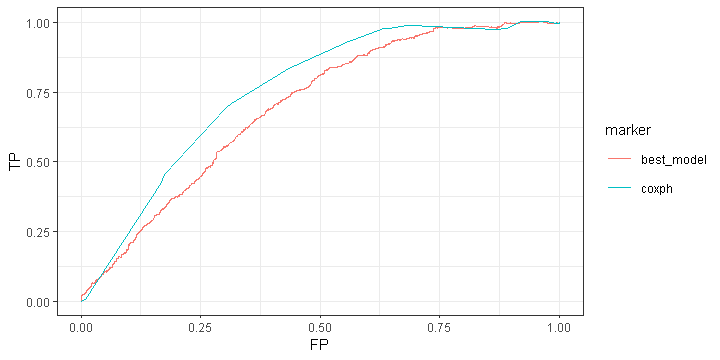

In [60]:
# Plot the ROC curves
dfl <- map(ROC, ~ with(., tibble(cutoff = cut.values, FP, TP)))
for(nm in names(dfl)) {dfl[[ nm ]]$marker <- nm}
dat <- do.call(rbind, dfl)
options(repr.plot.width=6, repr.plot.height=3)
ggplot(dat, aes(FP, TP, color = marker)) +
  geom_line() + theme_bw(base_size = 9)

In [61]:
# What are the AUC values ?
map_dbl(ROC, "AUC")

coxph best_model 
 0.7554124  0.6970765

> It clearly turns out that the best model performs predictions much better than the coxph_1 model with only 2 features over the test data. 


## Conclusion of part I : 

We performed survival analysis on the resort booking. 
- We have shown the survival curves of the booking : larger a booking period, higher a booking cancellation probability is.
- All features we proposed for Cox regression were justified by non-parametric survival approaches (Kapler-Meier, logrank test) and semi-parametric hazard appoach (CoxPH)
- The final model for predictions selected is the model which contains all the features we discussed. The results are tested with the same dataset. The AUC ratio = 0.755 we obtained for this model is quite relevant for this kind of dataset. 
- Perspective : we can improve the predictions by investigating the model diagnostics. For example, we may estimates *Martingale residuals* (see *Annexe*) to figure out if there are extra correlations of the features with the outcome. We may also use *case deletion residuals* (see *Annexe*) to explore "exceptional data" that we can remove to improve the performance of the model.

# Part II : Dataset CityHotel Booking (H2)

*The analysis of this dataset is similar to the previous one. Only the model selection and prediction are shown below.*

**Step-wise model selection:**

In [95]:
AIC_stepwise <- step(fit.full_model)

Start:  AIC=651203.7
Surv(LeadTime, IsCanceled) ~ DepositType + ADR + DistributionChannel + 
    ArrivalDateMonth + StaysInWeekendNights + totalNights + Adults + 
    havingKids + Babies

                       Df    AIC
- Babies                1 651203
<none>                    651204
- DistributionChannel   1 651222
- StaysInWeekendNights  1 651229
- havingKids            1 651246
- totalNights           1 651248
- Adults                1 651367
- ArrivalDateMonth      1 651409
- DepositType           1 651415
- ADR                   1 651687

Step:  AIC=651203.3
Surv(LeadTime, IsCanceled) ~ DepositType + ADR + DistributionChannel + 
    ArrivalDateMonth + StaysInWeekendNights + totalNights + Adults + 
    havingKids

                       Df    AIC
<none>                    651203
- DistributionChannel   1 651221
- StaysInWeekendNights  1 651229
- havingKids            1 651244
- totalNights           1 651248
- Adults                1 651368
- ArrivalDateMonth      1 651409
- Depo

> The stepwise technique confirms the unsignificant effect of *Babies* feature in the model. Thus, the "best" model does NOT include this feature.


#### Split data into test and train

We split without randomness

In [115]:
len_hotel = dim(hotelCoxph)[1]
hotel_train = head(hotelCoxph, len_hotel*0.8)
hotel_test = tail(hotelCoxph,len_hotel*0.2)

#### Prediction and evaluation of the best model: 
As part I, we build here a hotel_trained_coxph model for comparison with the trained_best_model

In [116]:
hotel_trained_best_model <- coxph(Surv(LeadTime, IsCanceled) ~ DepositType + ADR + DistributionChannel + 
    ArrivalDateMonth + StaysInWeekendNights + totalNights + Adults + havingKids, data = hotel_train)
hotel_pred_test_best_model <- mutate(hotel_test,lp= predict(hotel_trained_best_model, newdata = hotel_test, 
                                                            type = "lp"))
# Define hotel_trained_coxph and predict with this model
hotel_trained_coxph <- coxph(Surv(LeadTime, IsCanceled) ~ DepositType + ADR + DistributionChannel+ 
                             totalNights + ArrivalDateMonth, data = hotel_train)
hotel_pred_test_coxph <- mutate(hotel_test,lp = predict(hotel_trained_coxph, 
                                                        newdata = hotel_test, type = "lp"))

In [117]:
# Estimate the ROC of each model
ROC.hotel_coxph <- survivalROC(Stime =  hotel_pred_test_coxph$LeadTime, status = hotel_pred_test_coxph$IsCanceled,
                           marker = hotel_pred_test_coxph$lp, predict.time = 60/30.5,method="KM")
ROC.hotel_best_model <- survivalROC(Stime =  hotel_pred_test_best_model$LeadTime, status = hotel_pred_test_best_model$IsCanceled,
                           marker = hotel_pred_test_best_model$lp,predict.time = 60/30.5, method="KM")

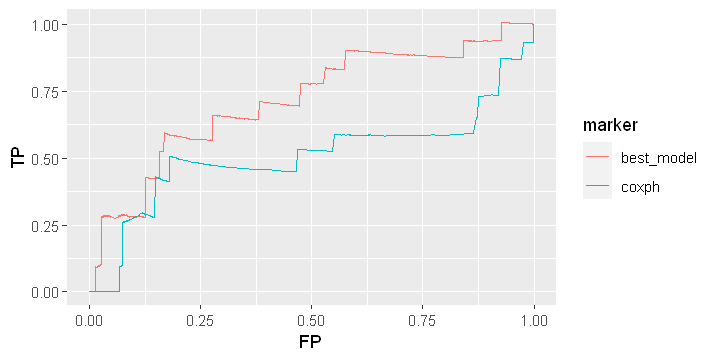

In [118]:
# Plot the ROC curves
ROC <- list(coxph = ROC.hotel_coxph, best_model = ROC.hotel_best_model)
dfl <- map(ROC, ~ with(., tibble(cutoff = cut.values, FP, TP)))
for(nm in names(dfl)) {
  dfl[[ nm ]]$marker <- nm}
dat <- do.call(rbind, dfl)
options(repr.plot.width=6, repr.plot.height=3)
ggplot(dat, aes(FP, TP, color = marker)) +
  geom_line()

In [119]:
# What are the AUC values ?
map_dbl(ROC, "AUC")

coxph best_model 
 0.5082072  0.7154114

## Conclusion part II

The AUC ratio = 0.72 for the "best" model is relevant, its performance much better than the trained_coxph model. We conclude that the stepwise strategy is a good choice to select the model for this kind of dataset. Of course, we can try another technique to find out a more appropriate model or simply by including more features for the best or for the worse ! 

# General conlusion for two datasets

I have investigated the survival analysis of the two datasets (resort/city hotel booking) that reveals  different behaviours depending on the booking category (resort/city hotel). It is shown that the impact of the features would be a key factor in a cancellation or not for a resort/city hotel booking. For instance, *Babies* exhibits a relevant impact in a resort booking as compared with a city hotel booking. Finally, the prediction models compiled with the stepwise approach exhibit a reliable prediction for both datasets, that indicates that a AIC-based stepwise technique is a simple and a good approach for a regression problem in survival analysis. 

---
### Annexe : Matingale residuals, case deletion residuals (Resort dataset)

**Martingale residuals:**

In [120]:
# We have to group the covariates of the resort_train dataset as we did for coxph analysis

resort_train_group <- resort_train %>%
                    mutate(DistributionChannel = factor(ifelse(DistributionChannel=="Direct", 
                                                    "Direct", "Mediator"),  levels = c("Direct", "Mediator")),
                   Babies = factor(ifelse(Babies==0,"No", "Yes"), levels = c("No", "Yes")),
                   DepositType = factor(ifelse(DepositType=="Non Refund", "Non Refund", "Refund"), 
                                        levels = c("Non Refund", "Refund")))

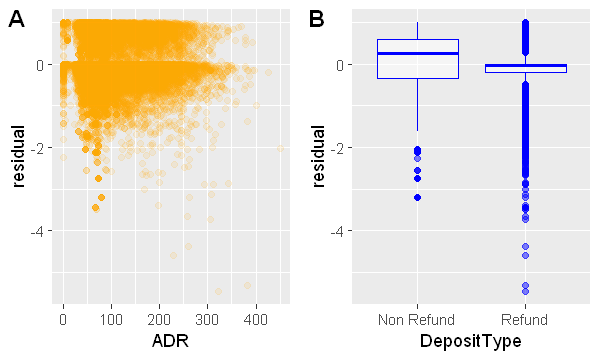

In [121]:
resort_train_group$residual <- residuals(trained_best_model, type = "martingale")
fig1 <- ggplot(resort_train_group, aes(ADR, residual)) +  
       geom_point(alpha = 0.1, color = "orange")
fig2 <- ggplot(resort_train_group, aes(DepositType, residual)) +  
       geom_boxplot(alpha = 0.5, color= "blue")
options(repr.plot.width=5, repr.plot.height=3)
ggarrange(fig1,fig2,labels = c("A", "B"), ncol = 2, nrow = 1)

**Case deletion residuals :**


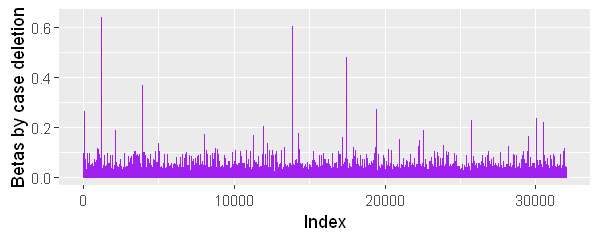

In [123]:
dfbetas <- residuals(trained_best_model, type = 'dfbetas')
resort_train_group$dfbetas <- sqrt(rowSums(dfbetas^2))
options(repr.plot.width=5, repr.plot.height=2)
ggplot(resort_train_group, aes(x = as.numeric(row.names(resort_train_group)), y=dfbetas))+
    xlab("Index") +
    ylab("Betas by case deletion") +
    geom_line(color = "purple")

In [126]:
# Here are "outliers" causing  high $\betas$ (>0.4) : 
filter(resort_train_group, dfbetas>0.3)

IsCanceled,LeadTime,ArrivalDateMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,ADR,DistributionChannel,DepositType,BookToCancel,havingKids,totalNights,residual,dfbetas
<int>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,11.081967,Other Season,2,0,55,0,Yes,0,Direct,Refund,63,0,2,0.7377748,0.6402593
1,10.459016,Other Season,0,1,2,0,Yes,382,Mediator,Refund,6,0,1,-5.3002075,0.3680736
1,11.016393,Other Season,1,2,50,0,Yes,0,Direct,Refund,104,0,3,0.7640538,0.6010699
1,9.967213,Other Season,0,3,40,0,Yes,0,Direct,Refund,60,0,3,0.7692484,0.4809760
